In [1]:
from sklearn.preprocessing import LabelEncoder
from src.dataset import FrameDataset
from torch.utils.data import DataLoader
from src.utils import collate_fn
import torch
import os
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm 

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from src.config import hparams

Initiating the model to test, the label encoder as well as the dataset and dataloaders

In [2]:
le = LabelEncoder()
le.fit(['apadding', 'bicycle','human', 'motorcycle', 'vehicle']);

In [3]:
device = torch.device('cuda')
model = torch.load('products/epoch20-best_model.pth')#Insert model path here
model.eval()
model.to(device);

In [4]:
#This only works if your relative paths to the data are exactly the same as the .txt file. Otherwise you need to find a different way to feed them in the dataset class.
file = open('test_dataset.txt', 'r')
test_data = file.read().split('\n')
del test_data[-1]

test_dataset = FrameDataset('', le)
test_dataset.img_files = test_data

In [5]:
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=collate_fn)

Calculating Mean Average Precision and Recall

In [6]:
#Initializing metrics
mAP = MeanAveragePrecision(iou_type = 'bbox', class_metrics=True)

In [7]:
prog_bar = tqdm(test_dataloader, total=len(test_dataloader))
for frames, targets in prog_bar:
    with torch.no_grad():
        frames = [frame.to(device) for frame in frames]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        prediction = model(frames)
        mAP.update(prediction, targets)


from pprint import pprint
pprint(mAP.compute())

  0%|          | 1/1038 [00:01<17:55,  1.04s/it]

Extracting visual results on random test frames

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)#Batch size = 1
frame, _ = next(iter(test_dataloader))#We don't need the true targets
img = frame[0].numpy().transpose(1, 2 , 0)

with torch.no_grad():
    prediction = model(frame)

boxes = prediction[0]['boxes'].numpy()
labels = prediction[0]['labels'].numpy()
scores = prediction[0]['scores'].numpy()
labels = le.inverse_transform(labels)


for box, label, score in zip(boxes, labels, scores):
    if score > 0.5:
        x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        label = label
        plt.text(x1, y1, label, fontsize = 12, c='white')
        plt.gca().add_patch(Rectangle((x1,y1),(x2-x1),(y2-y1),
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
    
plt.show()

Extracting visual results on video clips

In [28]:
video_path = 'data/train/clips/20200710/clip_35_1535.mp4'
cap = cv.VideoCapture(video_path)
output_path = 'outputs/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
counter = 0
while(True):
    ret, frame = cap.read()
    if (ret == True):
        if counter%25 == 0:
            tens_frame = (frame/255).transpose((2, 0, 1))
            tens_frame = torch.tensor(tens_frame).type(torch.float).unsqueeze(0)
            with torch.no_grad():
                prediction = model(tens_frame)

            boxes = prediction[0]['boxes'].numpy()
            labels = prediction[0]['labels'].numpy()
            scores = prediction[0]['scores'].numpy()
            labels = le.inverse_transform(labels)

            for box, label, score in zip(boxes, labels, scores):
                if score > 0.5:
                    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

                    cv.putText(frame,label,(x1,y1-4),cv.FONT_HERSHEY_SIMPLEX,0.4,(0,255,0),1,cv.LINE_AA)
                    cv.rectangle(frame,(x1, y1),(x2, y2),(255,0,0),1)
            path = os.path.join(output_path, 'frame' + str(counter) + '.jpg')
            cv.imshow('video', frame)
            counter += 1
            if cv.waitKey(100) & 0xFF == ord('q'):
                cv.destroyAllWindows()
                break
            
        else:
            counter += 1
        
    else: 
        cv.destroyAllWindows()
        break

Plotting the train vs validation loss curves from file

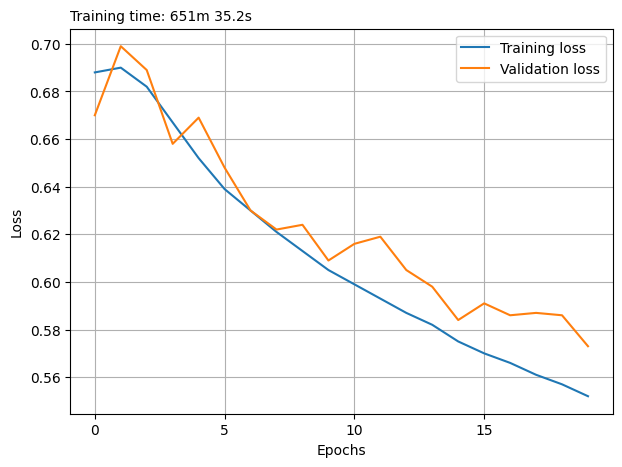

In [22]:
from matplotlib import pyplot as plt
import pandas as pd
fig, axes = plt.subplots(figsize = (7,5))
losses = pd.read_csv('losses.csv', header=None, sep=' ', names=['Training loss', 'Validation loss'])
losses.plot(xlabel='Epochs',
    xticks=range(0, 20, 5),
    ylabel='Loss',
    grid=True,
    ax=axes)
axes.set_title('Training time: 651m 35.2s', loc='left', size = 10)
plt.show()